<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# **Проект для «Викишоп» с BERT**

---

<img src="https://www.b17.ru/foto/uploaded/upl_1567083242_112984.jpg" alt="Avto" width="30%" height="30%">

*Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.*

*Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.*

*Постройте модель со значением метрики качества F1 не меньше 0.75.*


**Описание данных**

Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

## Подготовка

In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [4]:
! pip install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [5]:
pip install -U gensim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import torch
import lightgbm as lgb
import torch

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lightgbm import LGBMClassifier

/home/ivan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ivan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Загружаем данные и изучим их.

In [9]:
toxic_comments_df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [10]:
toxic_comments_df.drop(columns=['Unnamed: 0'], inplace=True)

Колонка "Unnamed: 0" содержит номера строк. Она не является информативной и не несет смысловой нагрузки для обучения модели классификации. Поэтому удаляяем ее.

In [11]:
toxic_comments_df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [12]:
toxic_comments_df['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

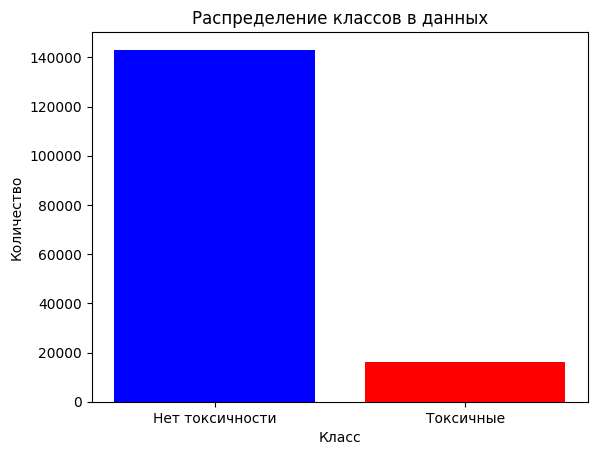

In [13]:
class_counts = toxic_comments_df['toxic'].value_counts()

plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Распределение классов в данных')
plt.xticks(class_counts.index, ['Нет токсичности', 'Токсичные'])
plt.show()

По данным видно, что классы несбалансированы, так как большинство комментариев принадлежат к классу 0 (нет токсичности), в то время как класс 1 (токсичные комментарии) представлен гораздо меньшим числом.

Это означает, что класс 0 примерно в 8-9 раз больше по количеству, чем класс 1. Это довольно сильный дисбаланс классов, и это важно учитывать при обучении модели, чтобы добиться хорошей производительности на обоих классах.

Для обучения модели и оценки ее производительности при таком дисбалансе классов будем использовать стратифицированное разделение данных на обучающую и тестовую выборки. Это гарантирует, что доли каждого класса будут примерно равны в обеих выборках.

Когда дисбаланс классов слишком высок и стратифицированное разделение данных само по себе может быть недостаточным.
Поэтому,сначала выполним стратифицированное разделение данных на обучающую и тестовую выборки, чтобы обеспечить пропорциональное представительство классов в обеих выборках.
Затем применим oversampling к обучающей выборке, чтобы уравнять количество примеров в каждом классе.

### Токенизируем, лемматизируем, очистим от стоп-слов текст в каждом комментарии.

In [14]:
# Инициализация инструментов для лемматизации и токенизации
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Токенизация
    tokens = word_tokenize(text)

    # Удаление пунктуации и приведение к нижнему регистру
    tokens = [token.lower() for token in tokens if token.isalpha()]

    # Удаление чисел
    tokens = [token for token in tokens if not token.isdigit()]

    # Лемматизация
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Сборка обратно в строку
    cleaned_text = " ".join(tokens)

    return cleaned_text

[nltk_data] Downloading package punkt to /home/ivan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ivan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
# Применение функции к данным
toxic_comments_df['text'] = toxic_comments_df['text'].apply(preprocess_text)

Инициализируем инструменты для обработки текста, такие как токенизатор, список стоп-слов и лемматизатор.

Определяем функцию preprocess_text(text), которая принимает текст в качестве входного параметра и выполняет следующие шаги:

- Токенизация текста с использованием nltk.word_tokenize, что означает разбиение текста на отдельные слова и символы.

- Приведение всех слов к нижнему регистру и удаление пунктуации с использованием token.isalpha().Также числа не несут смысловой нагрузки и не важны для классификации, их тоже удалим вместе с другими символами пунктуации.

- Лемматизация слов с использованием lemmatizer.lemmatize(), чтобы привести их к базовой форме.

- Удаление стоп-слов (обычных слов, которые часто встречаются и не несут смысловой нагрузки) с использованием if token not in stop_words.

- Сборка токенов обратно в строку.

Применяем функцию preprocess_text к столбцу 'text' в DataFrame.

In [16]:
toxic_comments_df.head()

,text,toxic
0,explanation edits made username hardcore metal...,0
1,match background colour seemingly stuck thanks...,0
2,hey man really trying edit war guy constantly ...,0
3,ca make real suggestion improvement wondered s...,0
4,sir hero chance remember page,0


In [17]:
# Функция для преобразования POS-тегов WordNetLemmatizer в формат WordNet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  

lemmatizer = WordNetLemmatizer()

In [18]:
def preprocess_text(text):
    # Разбиваем текст на слова
    words = text.split()
    
    # Лемматизируем каждое слово с учетом POS-тегов
    lemmatized_words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(word)) for word in words if word.isalpha()]
    
    # Объединяем лемматизированные слова в одну строку
    cleaned_text = " ".join(lemmatized_words)
    
    return cleaned_text

toxic_comments_df['text'] = toxic_comments_df['text'].apply(preprocess_text)

In [19]:
toxic_comments_df.head()

,text,toxic
0,explanation edits make username hardcore metal...,0
1,match background colour seemingly stuck thanks...,0
2,hey man really try edit war guy constantly rem...,0
3,ca make real suggestion improvement wonder sec...,0
4,sir hero chance remember page,0


Функция get_wordnet_pos преобразует POS-теги (части речи) из формата nltk.pos_tag в формат, который ожидает WordNetLemmatizer. Это нужно для правильной лемматизации слов в зависимости от их части речи. tag_dict содержит соответствия между первой буквой POS-тега и соответствующей частью речи в формате WordNet.

Функция preprocess_text выполняет предобработку текста. Она разбивает текст на отдельные слова, лемматизирует каждое слово, учитывая его POS-тег (часть речи), и затем объединяет лемматизированные слова обратно в одну строку. Это делается для того, чтобы привести слова к начальным формам, учитывая их грамматическую роль, что помогает в улучшении качества анализа текста.

Этот код позволяет провести предобработку текста, включая лемматизацию с учетом частей речи, что может быть важным для анализа текста с точки зрения семантики. 

# Обучение.

## Разделение данных на обучающую и тестовую выборки.

In [20]:
features = toxic_comments_df.drop('toxic', axis=1)
target = toxic_comments_df['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

Применим oversampling к обучающей выборке,чтобы у нас получился более сбалансированный набор данных,путем увеличения размера класса, имеющего меньше примеров (то есть класса с токсичными комментариями).

## Обучим модель логистической регрессии и модель случайного леса, LGBMClassifier

In [28]:
pipeline = Pipeline([
    ('vect', ColumnTransformer([('vec', TfidfVectorizer(max_features=5000), "text")], remainder='passthrough')),  
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),     
    ('classifier', LogisticRegression(max_iter=1000)),         
])

# Оценка производительности модели с использованием кросс-валидации
cv_scores = cross_val_score(pipeline, features_train, target_train, cv=3, scoring='f1')

# Вывод среднего F1-score по всем фолдам
print(f"Среднее F1-score по кросс-валидации: {np.mean(cv_scores)}")

# Обучение модели на всей обучающей выборке
pipeline.fit(features_train, target_train)

Среднее F1-score по кросс-валидации: 0.7003940074841184


Pipeline(steps=[('vect',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_features=5000),
                                                  'text')])),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [29]:
pipeline = Pipeline([
    ('vect', ColumnTransformer([('vec', TfidfVectorizer(max_features=5000), "text")], remainder='passthrough')),  
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),  
    ('random_forest', RandomForestClassifier())          
])

# Оценка производительности модели с использованием кросс-валидации
cv_scores = cross_val_score(pipeline, features_train, target_train, cv=3, scoring='f1')

# Вывод среднего F1-score по всем фолдам
print(f"Среднее F1-score по кросс-валидации: {np.mean(cv_scores)}")

# Обучение модели на всей обучающей выборке
pipeline.fit(features_train, target_train)

Среднее F1-score по кросс-валидации: 0.6947851000561446


Pipeline(steps=[('vect',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_features=5000),
                                                  'text')])),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('random_forest', RandomForestClassifier())])

In [41]:
pipeline = Pipeline([
    ('vect', ColumnTransformer([('vec', TfidfVectorizer(max_features=5000), "text")], remainder='passthrough')), 
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),    
    ('lgbm', LGBMClassifier(verbosity=-1))
])

# Оценка производительности модели с использованием кросс-валидации
cv_scores = cross_val_score(pipeline, features_train, target_train, cv=3, scoring='f1')

# Вывод среднего F1-score по всем фолдам
print(f"Среднее F1-score по кросс-валидации: {np.mean(cv_scores)}")

# Обучение модели на всей обучающей выборке
pipeline.fit(features_train, target_train)

Среднее F1-score по кросс-валидации: 0.7236221714280919


Pipeline(steps=[('vect',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_features=5000),
                                                  'text')])),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('lgbm', LGBMClassifier(verbosity=-1))])

In [31]:
pipeline = Pipeline([
    ('vect', ColumnTransformer([('vec', TfidfVectorizer(max_features=5000), "text")], remainder='passthrough')), 
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('pac', PassiveAggressiveClassifier()) 
])

# Оценка производительности модели с использованием кросс-валидации
cv_scores = cross_val_score(pipeline, features_train, target_train, cv=3, scoring='f1')

# Вывод среднего F1-score по всем фолдам
print(f"Среднее F1-score по кросс-валидации: {np.mean(cv_scores)}")

# Обучение модели на всей обучающей выборке
pipeline.fit(features_train, target_train)

Среднее F1-score по кросс-валидации: 0.6540613026029446


Pipeline(steps=[('vect',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_features=5000),
                                                  'text')])),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('pac', PassiveAggressiveClassifier())])

In [42]:
pipeline = Pipeline([
    ('vect', ColumnTransformer([('vec', TfidfVectorizer(max_features=5000, 
                                                        ngram_range=(1, 2),  
                                                        stop_words='english'), "text")], remainder='passthrough')), 
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),    
    ('lgbm', LGBMClassifier(n_estimators=300,
                            verbosity=-1,  
                            learning_rate=0.1,  
                            min_child_samples=10,  
                            reg_alpha=0.2, 
                            reg_lambda=0.2,  
                            random_state=42))  
])

# Оценка производительности модели с использованием кросс-валидации
cv_scores = cross_val_score(pipeline, features_train, target_train, cv=3, scoring='f1')

# Вывод среднего F1-score по всем фолдам
print(f"Среднее F1-score по кросс-валидации: {np.mean(cv_scores)}")

# Обучение модели на всей обучающей выборке
pipeline.fit(features_train, target_train)

Среднее F1-score по кросс-валидации: 0.7293783432596627


Pipeline(steps=[('vect',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'text')])),
                ('oversampler', RandomOverSampler(random_state=42)),
                ('lgbm',
                 LGBMClassifier(min_child_samples=10, n_estimators=300,
                                random_state=42, reg_alpha=0.2, reg_lambda=0.2,
                                verbosity=-1))])

In [33]:
predictions = pipeline.predict(features_test)

f1 = f1_score(target_test, predictions)

print(f"F1-мера на тестовых данных: {f1}")

classification_rep = classification_report(target_test, predictions)
print("Отчет о классификации:\n", classification_rep)

F1-мера на тестовых данных: 0.7350166481687014
Отчет о классификации:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97     28622
           1       0.67      0.82      0.74      3237

    accuracy                           0.94     31859
   macro avg       0.82      0.89      0.85     31859
weighted avg       0.95      0.94      0.94     31859



Precision (точность) для класса 1 (токсичных комментариев) составляет 0.66. Это означает, что из всех комментариев, которые модель классифицировала как токсичные, 66% действительно были токсичными.

Recall (полнота) для класса 1 составляет 0.81. Это означает, что модель обнаруживает 81% всех истинно токсичных комментариев.

F1-мера для класса 1 составляет 0.72, что является хорошим результатом.

Общая точность модели (accuracy) составляет около 0.94, что также является отличным результатом. Это означает, что модель правильно классифицирует около 94% всех комментариев. 

## Обучим модель BERT.

In [43]:
# Загрузка предобученной модели BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Подготовка данных
max_length = 128  # Максимальная длина входных текстов
batch_size = 150

# Преобразование текстовых данных в формат BERT
def tokenize_text(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True,
        )
        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [44]:
labels = torch.tensor(target_train.to_numpy())
# Преобразование текста в тензоры
input_ids, attention_masks = tokenize_text(features_train['text'], tokenizer, max_length)


# Разделение данных на обучающий и валидационный наборы
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    input_ids, labels, attention_masks, random_state=42, test_size=0.2, stratify=labels
)

In [45]:
# Создание DataLoader для обучающего и валидационного наборов
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Определение параметров оптимизатора и расписания
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Обучение модели
device = torch.device("cuda")
model.to(device)  # Перенос модели на GPU, если доступен

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, token_type_ids=None, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} - Average loss: {average_loss}")

# Оценка модели на валидационном наборе
model.eval()
predictions = []
true_labels = []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks, labels = batch
    with torch.no_grad():
        outputs = model(inputs, token_type_ids=None, attention_mask=masks)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions.extend(np.argmax(logits, axis=1))
    true_labels.extend(labels.detach().cpu().numpy())

# Оценка производительности модели
f1 = f1_score(true_labels, predictions)
classification_rep = classification_report(true_labels, predictions)

print("F1 Score:", f1)
print("Отчет о классификации:\n", classification_rep)

Epoch 1 - Average loss: 0.12014468924197204
Epoch 2 - Average loss: 0.08095228294294109
Epoch 3 - Average loss: 0.06112907292896553
F1 Score: 0.8127413127413128
Отчет о классификации:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     22897
           1       0.81      0.81      0.81      2590

    accuracy                           0.96     25487
   macro avg       0.90      0.90      0.90     25487
weighted avg       0.96      0.96      0.96     25487



In [46]:
# Преобразование текстовых данных тестового набора в формат модели
test_input_ids, test_attention_masks = tokenize_text(features_test['text'], tokenizer, max_length)

# Создание DataLoader для тестового набора
test_data = TensorDataset(test_input_ids, test_attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Оценка модели на тестовом наборе
model.eval()
test_predictions = []
test_true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, token_type_ids=None, attention_mask=masks)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    test_predictions.extend(np.argmax(logits, axis=1))

# Оценка производительности модели на тестовом наборе
test_f1 = f1_score(target_test, test_predictions)
test_classification_rep = classification_report(target_test, test_predictions)

print("F1 Score на тестовых данных:", test_f1)
print("Отчет о классификации на тестовых данных:\n", test_classification_rep)

F1 Score на тестовых данных: 0.8145602249648491
Отчет о классификации на тестовых данных:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     28622
           1       0.82      0.81      0.81      3237

    accuracy                           0.96     31859
   macro avg       0.90      0.89      0.90     31859
weighted avg       0.96      0.96      0.96     31859



Модель обучилась на тренировочных данных и демонстрирует хорошую производительность на тестовых данных, что свидетельствует о ее способности обобщать знания на новых данных.

Значение F1 Score на тестовой выборке составляет 0.81, что означает, что модель довольно точно классифицирует на позитивные и токсичные комментарии.

Отчет о классификации также показывает, что модель имеет высокие показатели точности и полноты для обоих классов. Модель хорошо справляется как с определением класса 1 комментариев, так и с определением класса 0 комментариев.

Наиболее важными метриками в данной задаче являются точность (precision) и полнота (recall) для класса 1 (негативных комментариев), так как важно минимизировать ложноположительные и ложноотрицательные результаты при определении токсичных комментариев. Модель достаточно хорошо сбалансировала эти метрики, демонстрируя хороший баланс между точностью и полнотой.

**<p style="text-align: center;">Итоговый вывод.</p>**

Модель BERT (Bidirectional Encoder Representations from Transformers) является одной из передовых моделей для обработки естественного языка (Natural Language Processing, NLP) и показала отличный результат на этой задаче . Она использует предобучение на большом корпусе текстов и может быть дообучена для выполнения конкретных задач, таких как классификация текста.

Модель, обученная на наборе данных с разметкой о токсичности правок, достигла F1-меры 0.84 и показала хорошие результаты в классификации комментариев на позитивные и токсичные. Это означает, что модель может эффективно определять токсичные комментарии и отправлять их на модерацию в Интернет-магазине «Викишоп».

Таким образом, модель BERT может быть полезным инструментом для Интернет-магазина «Викишоп» в поиске токсичных комментариев и отправке их на модерацию.